<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill</span>


## 🗒️ This notebook is divided into the following sections:
1. Fetch historical data
2. Connect to the Hopsworks feature store
3. Create feature groups and insert them to the feature store



### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import requests
import pandas as pd
import hopsworks
import warnings
import datetime
from pathlib import Path
warnings.filterwarnings("ignore")

/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## <span style='color:#ff5f27'> 🌍 Download the Historical Air Quality </span>

https://aqicn.org/historical#!city:sweden/stockholm-hornsgatan-108-gata

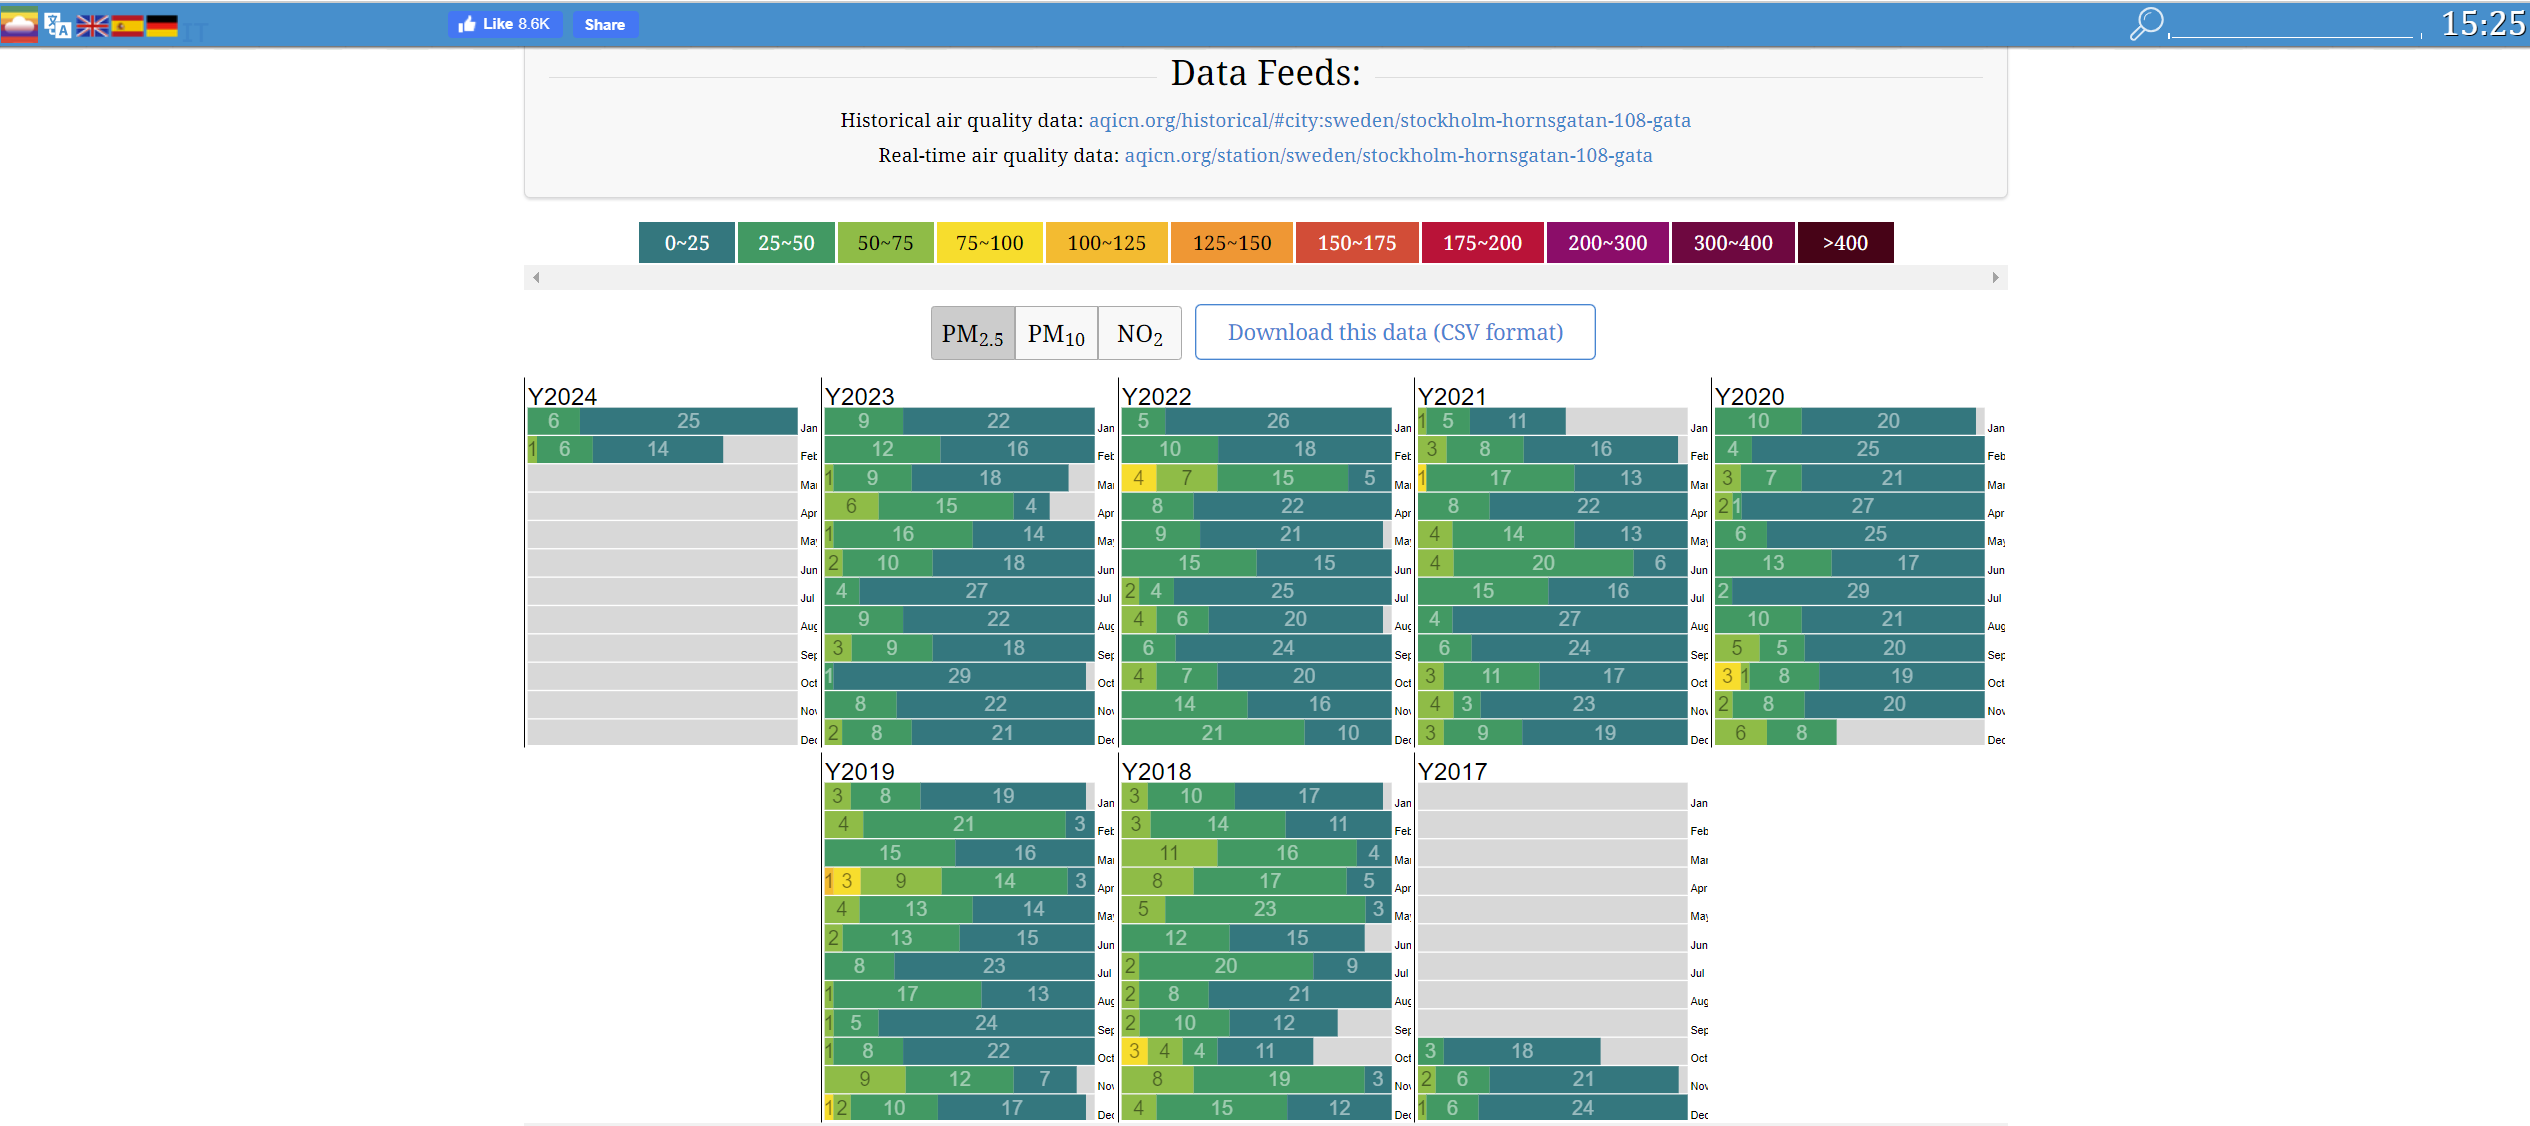


In [2]:
# My URL for my sensor is:
# https://aqicn.org/historical#!city:sweden/stockholm-hornsgatan-108-gata
# city == sweden
# street == stockholm-hornsgatan-108-gata

# Change the country to the first part of the filename for the CSV file you downloaded for your sensor
country="sweden"
# Change the city name below to the nearest city for weather data
city="stockholm"
# Change the street to the second part of the filename for the CSV file you downloaded for your sensor
street="stockholm-hornsgatan-108-gata"
csv_file="../../data/stockholm-hornsgatan 108 gata-air-quality.csv"

today = datetime.date.today()

In [3]:
df = pd.read_csv(csv_file,  parse_dates=['date'], skipinitialspace=True)
df.isna()

date   pm25   pm10    no2
0     False  False  False  False
1     False  False  False  False
2     False  False   True   True
3     False  False  False  False
4     False  False  False  False
...     ...    ...    ...    ...
2301  False   True   True  False
2302  False   True   True  False
2303  False   True   True  False
2304  False   True   True  False
2305  False   True   True  False

[2306 rows x 4 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2306 non-null   datetime64[ns]
 1   pm25    2269 non-null   float64       
 2   pm10    2269 non-null   float64       
 3   no2     2280 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 72.2 KB


In [6]:
from functions import *

df2 = df[['date', 'pm25']]
df2['country']=country
df2['city']=city
df2['street']=street

latitude, longitude = get_city_coordinates(city)

In [7]:
df2['pm25'] = df2['pm25'].astype('float32')
df2

date  pm25 country       city                         street
0    2024-03-01  46.0  sweden  stockholm  stockholm-hornsgatan-108-gata
1    2024-03-02  59.0  sweden  stockholm  stockholm-hornsgatan-108-gata
2    2024-03-03  48.0  sweden  stockholm  stockholm-hornsgatan-108-gata
3    2024-02-01  22.0  sweden  stockholm  stockholm-hornsgatan-108-gata
4    2024-02-02  22.0  sweden  stockholm  stockholm-hornsgatan-108-gata
...         ...   ...     ...        ...                            ...
2301 2017-10-24   NaN  sweden  stockholm  stockholm-hornsgatan-108-gata
2302 2017-10-25   NaN  sweden  stockholm  stockholm-hornsgatan-108-gata
2303 2017-10-26   NaN  sweden  stockholm  stockholm-hornsgatan-108-gata
2304 2017-10-27   NaN  sweden  stockholm  stockholm-hornsgatan-108-gata
2305 2017-10-28   NaN  sweden  stockholm  stockholm-hornsgatan-108-gata

[2306 rows x 5 columns]

In [8]:
df2.dropna(inplace=True)
df2

date  pm25 country       city                         street
0    2024-03-01  46.0  sweden  stockholm  stockholm-hornsgatan-108-gata
1    2024-03-02  59.0  sweden  stockholm  stockholm-hornsgatan-108-gata
2    2024-03-03  48.0  sweden  stockholm  stockholm-hornsgatan-108-gata
3    2024-02-01  22.0  sweden  stockholm  stockholm-hornsgatan-108-gata
4    2024-02-02  22.0  sweden  stockholm  stockholm-hornsgatan-108-gata
...         ...   ...     ...        ...                            ...
2264 2017-12-26  16.0  sweden  stockholm  stockholm-hornsgatan-108-gata
2265 2017-12-27  10.0  sweden  stockholm  stockholm-hornsgatan-108-gata
2266 2017-12-28  55.0  sweden  stockholm  stockholm-hornsgatan-108-gata
2267 2017-12-29  42.0  sweden  stockholm  stockholm-hornsgatan-108-gata
2268 2017-12-30  16.0  sweden  stockholm  stockholm-hornsgatan-108-gata

[2269 rows x 5 columns]

In [9]:
earliest_aq_date = pd.Series.min(df2['date'])

In [10]:
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

'2017-10-04'

In [11]:
df_air_quality=df2
df_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2269 entries, 0 to 2268
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2269 non-null   datetime64[ns]
 1   pm25     2269 non-null   float32       
 2   country  2269 non-null   object        
 3   city     2269 non-null   object        
 4   street   2269 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 97.5+ KB


### <span style="color:#ff5f27;">🛠 Feature Engineering</span>

In [12]:
# Print the shape (number of rows and columns) of the df_air_quality DataFrame
df_air_quality.shape

(2269, 5)

In [13]:
# Retrieve and display the column names of the df_air_quality DataFrame
df_air_quality.columns

Index(['date', 'pm25', 'country', 'city', 'street'], dtype='object')

---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## Instructions for weather
https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

In [17]:
weather_df = get_historical_weather(city, earliest_aq_date, str(today))

Coordinates 59.29701232910156°N 18.163265228271484°E
Elevation 18.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [18]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2344 entries, 0 to 2343
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         2344 non-null   datetime64[ns]
 1   temperature_2m_mean          2344 non-null   float32       
 2   precipitation_sum            2344 non-null   float32       
 3   wind_speed_10m_max           2344 non-null   float32       
 4   wind_direction_10m_dominant  2344 non-null   float32       
 5   city                         2344 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 91.6+ KB


In [19]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":999.9,
            "strict_min":True
        }
    )
)

{"expectation_type": "expect_column_min_to_be_between", "meta": {}, "kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 999.9, "strict_min": true}}

In [20]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

---

### <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [21]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works:443/p/5240
Connected. Call `.close()` to terminate connection gracefully.


In [22]:
df_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2269 entries, 0 to 2268
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2269 non-null   datetime64[ns]
 1   pm25     2269 non-null   float32       
 2   country  2269 non-null   object        
 3   city     2269 non-null   object        
 4   street   2269 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 97.5+ KB


## <span style="color:#ff5f27;">🪄 Creating Feature Groups</span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data

In [23]:
# Get or create feature group
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['country','street','date'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)    

In [24]:
# Insert data
air_quality_fg.insert(df_air_quality)

Validation succeeded.
Validation Report saved successfully, explore a summary at https://snurran.hops.works:443/p/5240/fs/5188/fg/7232


Uploading Dataframe: 100.00% |███████████████████████████████████████████████████████████████████████████| Rows 2269/2269 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fe2d02e4a00>,
 {
   "statistics": {
     "evaluated_expectations": 1,
     "successful_expectations": 1,
     "unsuccessful_expectations": 0,
     "success_percent": 100.0
   },
   "evaluation_parameters": {},
   "success": true,
   "meta": {
     "great_expectations_version": "0.15.12",
     "expectation_suite_name": "aq_expectation_suite",
     "run_id": {
       "run_name": null,
       "run_time": "2024-03-05T21:00:57.960506+00:00"
     },
     "batch_kwargs": {
       "ge_batch_id": "76e4e542-db33-11ee-b3c3-00155dd09873"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20240305T210057.960386Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.15.12"
     }
   },
   "results": [
     {
       "result": {
         "observed_value": 4.0,
         "element_count": 2269,
         "missing_count": null,
         "missing_percent": null
       },
       "expectation_config": {
         "expectation_t

In [25]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")

### <span style='color:#ff5f27'> 🌦 Weather Data

In [29]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city','date'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

In [30]:
# Insert data
weather_fg.insert(weather_df)

Validation succeeded.
Validation Report saved successfully, explore a summary at https://snurran.hops.works:443/p/5240/fs/5188/fg/7233


Uploading Dataframe: 100.00% |███████████████████████████████████████████████████████████████████████████| Rows 2344/2344 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fe2d02a4c70>,
 {
   "statistics": {
     "evaluated_expectations": 2,
     "successful_expectations": 2,
     "unsuccessful_expectations": 0,
     "success_percent": 100.0
   },
   "evaluation_parameters": {},
   "success": true,
   "meta": {
     "great_expectations_version": "0.15.12",
     "expectation_suite_name": "weather_expectation_suite",
     "run_id": {
       "run_name": null,
       "run_time": "2024-03-05T21:20:59.676061+00:00"
     },
     "batch_kwargs": {
       "ge_batch_id": "432c1bc8-db36-11ee-b3c3-00155dd09873"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20240305T212059.675892Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.15.12"
     }
   },
   "results": [
     {
       "result": {
         "observed_value": 3.41525936126709,
         "element_count": 2344,
         "missing_count": null,
         "missing_percent": null
       },
       "expectation_config": {
     

In [28]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Feature Pipeline 
 </span> 

In the following notebook you will parse data and insert it into Feature Groups.

## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 
    
    * Add a rolling window of 3 days and 5 days for 'pm25'
        df.set_index("date").rolling(3).mean().head()
